In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install bezier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
import timeseriesanalysis as tsa
from numba import njit
import itertools

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.3 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
lang

/usr/local/lib/python3.10/dist-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


TypeError: 

In [3]:
def arithmetic_mean(data, window_size):
    """
    Computes the arithmetic mean (simple moving average) over a sliding window.

    Parameters:
    data (numpy.ndarray): The input 1D array for which to compute the arithmetic mean.
    window_size (int): The size of the sliding window.

    Returns:
    numpy.ndarray: A 1D array of the arithmetic mean values, padded with zeros for alignment.
    """
    # Create a convolution kernel with equal weights
    kernel = np.ones(window_size) / window_size
    sma = np.convolve(data, kernel, mode='valid')

    # Prepend zeros to match the original data length
    mean = np.concatenate((np.zeros(len(data) - len(sma)), sma))

    return mean


In [4]:
def generate_polynomial_kernel(coefficients, window_size):
    """
    Generates a filter kernel by evaluating a polynomial defined by the given coefficients.

    Parameters:
    coefficients (numpy.ndarray): A 1D array of polynomial coefficients, ordered from highest to lowest degree.
    window_size (int): The size of the window over which the polynomial is evaluated.  Must equal len(coefficients).

    Returns:
    numpy.ndarray: A 1D array representing the normalized filter kernel.
    """
    if len(coefficients) != window_size:
        raise ValueError("The number of coefficients must equal the window size.")

    x = np.linspace(0, 1, window_size)  # Scale the x-values for polynomial evaluation.
    kernel = np.polyval(coefficients[::-1], x) #Evaluate the polynomial.  Flip the coefficients because numpy expects it in reverse.
    kernel_sum = np.sum(kernel)

    if kernel_sum != 0:
        kernel = kernel / kernel_sum
    else:
        return np.zeros(window_size) # or handle it in the error

    return kernel

def lti_filter_via_convolution_precomputed(data, kernel):
    """
    Applies a linear time-invariant (LTI) filter to the input data using convolution,
    assuming the kernel has already been precomputed and normalized.

    Parameters:
    data (numpy.ndarray): The input 1D array to be filtered.
    kernel (numpy.ndarray): The precomputed and normalized filter kernel.

    Returns:
    numpy.ndarray: A 1D array of the filtered data, padded with zeros for alignment.
    """
    filtered_data = np.convolve(data, kernel, mode='valid')
    padding_size = len(data) - len(filtered_data)
    filtered_data_padded = np.concatenate((np.zeros(padding_size), filtered_data))

    return filtered_data_padded


# Example Usage: Efficient Iteration
if __name__ == '__main__':
    data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    window_size = 3
    coefficient_sets = [
        np.array([0.1, 0.2, 0.7]),  # linear
        np.array([0.25, 0.5, 0.25]), # linear
        np.array([-0.5, 1.0, -0.5]), # linear
        np.array([1, 0, 0]),       #Quadratic
        np.array([1, 1, 1])        #Quadratic
    ]

    # Precompute the kernels
    kernels = [generate_polynomial_kernel(coeffs, window_size) for coeffs in coefficient_sets]

    # Now, efficiently iterate and apply the filters
    for i, kernel in enumerate(kernels):
        filtered_data = lti_filter_via_convolution_precomputed(data, kernel)
        print(f"Filtered data for coefficient set {i+1}:", filtered_data)
        print(f"Kernel values for coefficient set {i+1}:", kernel)

Filtered data for coefficient set 1: [0.         0.         1.38983051 2.38983051 3.38983051 4.38983051
 5.38983051 6.38983051 7.38983051 8.38983051]
Kernel values for coefficient set 1: [0.06779661 0.25423729 0.6779661 ]
Filtered data for coefficient set 2: [0.        0.        1.5862069 2.5862069 3.5862069 4.5862069 5.5862069
 6.5862069 7.5862069 8.5862069]
Kernel values for coefficient set 2: [0.13793103 0.31034483 0.55172414]
Filtered data for coefficient set 3: [0.  0.  2.8 3.8 4.8 5.8 6.8 7.8 8.8 9.8]
Kernel values for coefficient set 3: [ 0.8  0.2 -0. ]
Filtered data for coefficient set 4: [0. 0. 2. 3. 4. 5. 6. 7. 8. 9.]
Kernel values for coefficient set 4: [0.33333333 0.33333333 0.33333333]
Filtered data for coefficient set 5: [0.         0.         1.65217391 2.65217391 3.65217391 4.65217391
 5.65217391 6.65217391 7.65217391 8.65217391]
Kernel values for coefficient set 5: [0.17391304 0.30434783 0.52173913]


In [5]:
@njit
def generate_polynomial_kernel(coefficients, window_size):
    """
    Generates a filter kernel by evaluating a polynomial defined by the given coefficients.
    Numba-optimized for speed.  Uses Horner's method for polynomial evaluation.

    Parameters:
    coefficients (numpy.ndarray): A 1D array of polynomial coefficients.
    window_size (int): The size of the window over which the polynomial is evaluated.

    Returns:
    numpy.ndarray: A 1D array representing the normalized filter kernel.
    """
    if len(coefficients) != window_size:
        raise ValueError("The number of coefficients must equal the window size.")

    x = np.linspace(0.0, 1.0, window_size)  # Important: Specify float dtype for Numba
    kernel = np.zeros(window_size, dtype=np.float64) # Important: define output as float
    degree = len(coefficients) - 1

    for i in range(window_size):
        xi = x[i]
        result = 0.0  # Horner's method
        for j in range(degree, -1, -1):
            result = result * xi + coefficients[j]
        kernel[i] = result


    kernel_sum = np.sum(kernel)

    if kernel_sum != 0.0:
        kernel = kernel / kernel_sum
    else:
        return np.zeros(window_size)

    return kernel

@njit
def convolve_valid(data, kernel):
    """
    Performs a 'valid' convolution of 1D arrays, optimized with Numba.

    Parameters:
    data (numpy.ndarray): The input 1D data array.
    kernel (numpy.ndarray): The 1D filter kernel.

    Returns:
    numpy.ndarray: The convolved array.
    """
    n = len(data)
    m = len(kernel)
    result_len = n - m + 1
    result = np.zeros(result_len, dtype=data.dtype)

    for i in range(result_len):
        for j in range(m):
            result[i] += data[i + j] * kernel[j]
    return result

def lti_filter_via_convolution_precomputed(data, kernel):
    """
    Applies a linear time-invariant (LTI) filter to the input data using precomputed
    kernel and optimized convolution.

    Parameters:
    data (numpy.ndarray): The input 1D array to be filtered.
    kernel (numpy.ndarray): The precomputed filter kernel.

    Returns:
    numpy.ndarray: A 1D array of the filtered data, padded with zeros for alignment.
    """
    filtered_data = convolve_valid(data, kernel)
    padding_size = len(data) - len(filtered_data)
    filtered_data_padded = np.concatenate((np.zeros(padding_size), filtered_data))

    return filtered_data_padded

# Example Usage
if __name__ == '__main__':
    data = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]) #Float type is important for numba
    window_size = 5
    coefficient_sets = [
        np.array([0.1, 0.2, 0.7]),
        np.array([0.25, 0.5, 0.25]),
        np.array([-0.5, 1.0, -0.5]),
        np.array([1.0, 0.0, 0.0])
    ]

    # Precompute the kernels
    kernels = [generate_polynomial_kernel(coeffs, window_size) for coeffs in coefficient_sets]

    # Apply filters
    for i, kernel in enumerate(kernels):
        filtered_data = lti_filter_via_convolution_precomputed(data, kernel)
        print(f"Filtered data for coefficient set {i+1}:", filtered_data)

ValueError: The number of coefficients must equal the window size.

Polynomial with coefficients [1, 2, 3], window size 20, no normalization:
[1.     1.1075 1.23   1.3675 1.52   1.6875 1.87   2.0675 2.28   2.5075
 2.75   3.0075 3.28   3.5675 3.87   4.1875 4.52   4.8675 5.23   5.6075]

Sum of polynomial values: 57.525000000000006

Polynomial with coefficients [1, 2, 3], window size 20, normalized:
[0.01738375 0.0192525  0.02138201 0.02377227 0.02642329 0.02933507
 0.03250761 0.0359409  0.03963494 0.04358974 0.0478053  0.05228162
 0.05701869 0.06201651 0.0672751  0.07279444 0.07857453 0.08461538
 0.09091699 0.09747936]

Sum of normalized polynomial values: 1.0

Polynomial with coefficients [2, 8, -5, 6, 3, -4, 1], window size 20, normalized:
[0.01758775 0.02100213 0.02423822 0.02733996 0.03035281 0.0333227
 0.03629505 0.03931389 0.0424211  0.04565571 0.04905335 0.05264574
 0.05646035 0.06052009 0.06484314 0.06944286 0.07432782 0.0795019
 0.08496452 0.09071093]

Sum of normalized polynomial values: 1.0

Polynomial with coefficients [1, 2, -3, 1], window s

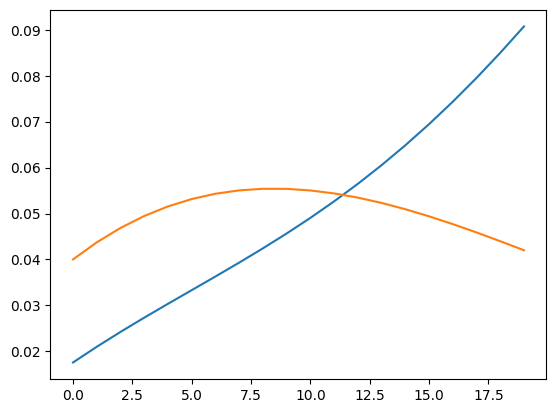

In [13]:
import numpy as np

def polynomial_constructor(coefficients, window_size, normalize=False):
  """
  Constructs a polynomial based on the given coefficients and window size.

  Args:
    coefficients: A list or numpy array of coefficients for the polynomial,
                  where coefficients[0] is the constant term, 
                  coefficients[1] is the coefficient of x, and so on.
    window_size: The desired number of points (data points) in the generated polynomial.
    normalize:  A boolean indicating whether the resulting polynomial values should be
                normalized to sum to 1. Defaults to False.

  Returns:
    A numpy array of length window_size containing the y-values of the polynomial
    evaluated at evenly spaced x-values within the range [0, 1).
    If normalize is True, the y-values will be scaled to sum to 1.
    Returns None if input is invalid.
  """

  if not isinstance(coefficients, (list, np.ndarray)):
    print("Error: Coefficients must be a list or numpy array.")
    return None

  if not isinstance(window_size, int) or window_size <= 0:
    print("Error: Window size must be a positive integer.")
    return None

  if not isinstance(normalize, bool):
    print("Error: Normalize must be a boolean value")
    return None

  # Create evenly spaced x-values in the range [0, 1)
  x_values = np.linspace(0, 1, window_size, endpoint=False)

  # Evaluate the polynomial at each x-value
  y_values = np.polyval(coefficients[::-1], x_values)

  if normalize:
    y_sum = np.sum(y_values)
    if y_sum == 0:  # Handle the case where the sum is zero to avoid division by zero
      print("Warning: Polynomial values sum to zero.  Cannot normalize.")
      return np.zeros_like(y_values) # Return all zeros to avoid errors. A valid solution is to divide by a near-zero constant.
    y_values = y_values / y_sum

  return y_values

if __name__ == '__main__':
  # Example usage:
  coefficients1 = [1, 2, 3]
  window_size1 = 20
  polynomial_points1 = polynomial_constructor(coefficients1, window_size1)
  print(f"Polynomial with coefficients {coefficients1}, window size {window_size1}, no normalization:\n{polynomial_points1}\n")
  print(f"Sum of polynomial values: {np.sum(polynomial_points1)}\n")

  polynomial_points_normalized1 = polynomial_constructor(coefficients1, window_size1, normalize=True)
  print(f"Polynomial with coefficients {coefficients1}, window size {window_size1}, normalized:\n{polynomial_points_normalized1}\n")
  print(f"Sum of normalized polynomial values: {np.sum(polynomial_points_normalized1)}\n")

  coefficients2 = [2, 8, -5, 6, 3, -4, 1]
  window_size2 = 20
  polynomial_points2 = polynomial_constructor(coefficients2, window_size2, normalize=True)
  plt.plot(polynomial_points2)
  print(f"Polynomial with coefficients {coefficients2}, window size {window_size2}, normalized:\n{polynomial_points2}\n")
  print(f"Sum of normalized polynomial values: {np.sum(polynomial_points2)}\n")

  coefficients3 = [1, 2, -3, 1]
  window_size3 = 20
  polynomial_points3 = polynomial_constructor(coefficients3, window_size3, normalize=True)
  plt.plot(polynomial_points3)
  print(f"Polynomial with coefficients {coefficients3}, window size {window_size3}, normalized:\n{polynomial_points3}\n")
  print(f"Sum of normalized polynomial values: {np.sum(polynomial_points3)}\n")

  # Example with zero sum
  coefficients4 = [0, 0, 0] #creates a set of all 0s.
  window_size4 = 10
  polynomial_points4 = polynomial_constructor(coefficients4, window_size4, normalize=True)
  
  print(f"Polynomial with coefficients {coefficients4}, window size {window_size4}, normalized:\n{polynomial_points4}\n")
  if polynomial_points4 is not None:
      print(f"Sum of normalized polynomial values: {np.sum(polynomial_points4)}\n") #this will not print in this zero case, since return is None.

In [8]:
import itertools

def generate_permutations(input_list):
  """
  Generates all permutations of the given list using the itertools library.

  Args:
    input_list: The list for which to generate permutations.

  Returns:
    A list of tuples, where each tuple represents a permutation of the input list.
  """
  return list(itertools.permutations(input_list))

# Example usage:
my_list = [-3, -2, -1, 0, 1, 2, 3]
permutations = generate_permutations(my_list)
print(len(permutations))  # Output: [(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

5040


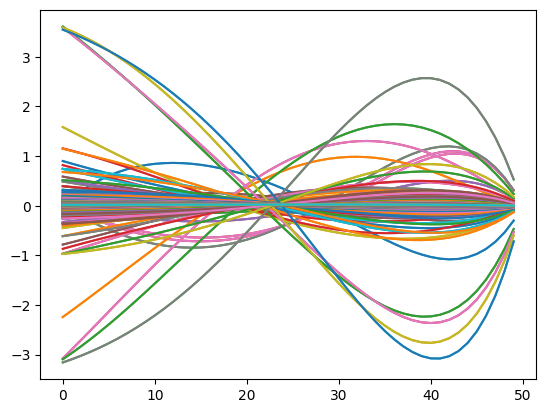

In [12]:
polys = []

for i in permutations:
    poly = polynomial_constructor(list(i), 50, normalize=True)
    polys.append(poly)
    plt.plot(poly)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
import scipy.linalg as la

def iterate_spline_space(x, df, x_fixed, y_fixed, order=3, n_iterations=10):
    """
    Iterates through a space of splines with a fixed number of degrees of freedom.

    Args:
        x (np.ndarray): x-values over which to evaluate the splines.
        df (int): Number of degrees of freedom for the splines.
        x_fixed (np.ndarray): Fixed locations in the domain of x that the spline must pass through.
        y_fixed (np.ndarray): Corresponding values of the spline function that x_fixed must pass through.
        order (int): Order of the B-splines (e.g., 3 for cubic).
        n_iterations (int): Number of different splines to generate.

    Returns:
        splines (list): List of spline functions.
    """

    n_fixed = len(x_fixed)
    n_basis_functions = df - n_fixed #number of free parameters/coefficients.

    # Place knots within the domain. Add additional knots on the outside to satisfy spline conditions
    knots = np.concatenate((np.repeat(x.min(), order),
                                    np.linspace(x.min(), x.max(), n_basis_functions + 2), #internal knots
                                    np.repeat(x.max(), order)))

    # Create the B-spline basis
    basis = [BSpline(knots, np.eye(len(knots) - order - 1)[k], order)
                for k in range(len(knots) - order - 1)]

    A = np.zeros((n_fixed, len(basis)))
    for i in range(n_fixed):
        for k in range(len(basis)):
            A[i,k] = basis[k](x_fixed[i])

    #Now we need to find coefficients that satisfy A*c = y_fixed
    basis_functions = A.shape[1]

    #Solve this system of equations for the first n_fixed coefficient (least squares).  Remaining coefficients will be free.
    Q, R = la.qr(A)
    Q = Q[:, :n_fixed]
    R = R[:n_fixed, :]
    c_solved = la.solve(R, Q.T @ y_fixed)
    print(c_solved)
    #store the coefficients we need to get the spline to pass through the fixed points.

    splines = []
    for i in range(n_iterations):
        # Generate random coefficients for the basis functions
        random_coefficients = np.random.randn(n_basis_functions)

        #Append the random coefficients to the end of the solved coefficients
        coefficients = np.concatenate((c_solved, random_coefficients))
        spline = BSpline(knots, coefficients, order)
        splines.append(spline)

    return splines


# Example usage:
x = np.linspace(0, 10, 100)  # x-values
df = 10  # Degrees of freedom
x_fixed = np.array([2, 5, 8]) # x values the spline must pass through
y_fixed = np.array([3, 1, 4]) # y values the spline must pass through
n_iterations = 5  # Number of splines to generate

splines = iterate_spline_space(x, df, x_fixed, y_fixed, n_iterations=n_iterations)

# Plot the results
plt.figure(figsize=(10, 6))
for spline in splines:
    plt.plot(x, spline(x))

plt.scatter(x_fixed, y_fixed, color='red', label='Fixed Points') # plot the fixed points.
plt.xlabel("x")
plt.ylabel("y")
plt.title("Splines with Fixed Degrees of Freedom")
plt.legend()
plt.show()

ValueError: Input a needs to be a square matrix.

<ipython-input-14-4332574ba46a>:49: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(kernel_values, t) # calculate integral


[<function iterate_polynomial_kernels.<locals>.kernel_function at 0x7886b546a4d0>, <function iterate_polynomial_kernels.<locals>.kernel_function at 0x7886bc498c10>, <function iterate_polynomial_kernels.<locals>.kernel_function at 0x7886b546a440>, <function iterate_polynomial_kernels.<locals>.kernel_function at 0x7886b546b250>, <function iterate_polynomial_kernels.<locals>.kernel_function at 0x7886b546b2e0>]


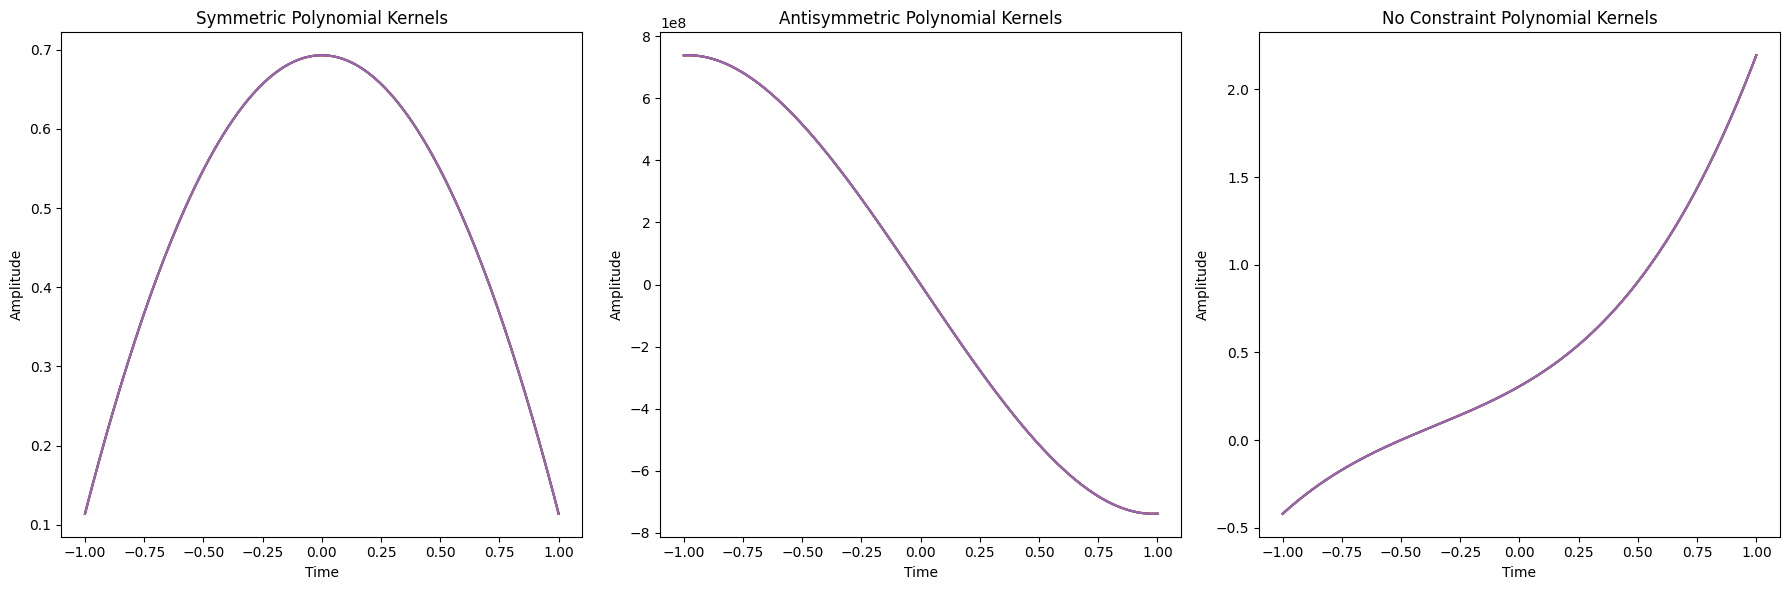

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

def iterate_polynomial_kernels(time_window, num_points, num_coefficients, n_iterations=10,
                                  symmetry='none', coefficient_range=(-1, 1), fixed_points = []):
    """
    Iterates through a space of polynomial kernels for time series analysis.

    Args:
        time_window (float): Length of the time window.
        num_points (int): Number of points to evaluate the kernel at.
        num_coefficients (int): Number of coefficients in the polynomial.
        n_iterations (int): Number of kernels to generate.
        symmetry (str): 'none', 'symmetric', or 'antisymmetric'.
        coefficient_range (tuple): Range of coefficient values.
        fixed_points (list): A list of tuple (t,y) to fix some points.
    Returns:
        kernels (list): List of kernel functions. Each function takes time (t) as input.
    """

    t = np.linspace(-time_window / 2, time_window / 2, num_points)
    kernels = []

    for _ in range(n_iterations):
        coefficients = np.random.uniform(coefficient_range[0], coefficient_range[1], num_coefficients)

        # Apply symmetry/antisymmetry constraints
        if symmetry == 'symmetric':
            # Set odd-power coefficients to 0
            for i in range(1, num_coefficients, 2): #Starts at 1, then increments by 2 (odd numbers only)
                coefficients[i] = 0 #Sets the ith term to 0.
        elif symmetry == 'antisymmetric':
            # Set even-power coefficients to 0
            for i in range(0, num_coefficients, 2):
                coefficients[i] = 0

        # Define the polynomial function
        def kernel(t_val):
            result = 0
            for i, c in enumerate(coefficients):
                result += c * (t_val ** i)
            return result

        # Evaluate the kernel function.
        kernel_values = kernel(t)

        #Normalise by some condition
        area = simps(kernel_values, t) # calculate integral

        kernel_values /= area # Normalise area to 1

        # Create function that interpolates and represents kernel.
        def kernel_function(t_in): #input a time and find the corresponding
          return np.interp(t_in, t, kernel_values)

        kernels.append(kernel_function)

    return kernels

# Example usage
time_window = 2.0  # Time window from -1 to 1
num_points = 200  # Number of points to evaluate the kernel
num_coefficients = 4 #degree 4 polynomial kernel
n_iterations = 5

#fixed_points = [(0,1)] # fixes the kernel to 1 at point 0. This function is broken however.
# Generate symmetric kernels
symmetric_kernels = iterate_polynomial_kernels(time_window, num_points, num_coefficients, n_iterations, symmetry='symmetric')

# Generate antisymmetric kernels
antisymmetric_kernels = iterate_polynomial_kernels(time_window, num_points, num_coefficients, n_iterations, symmetry='antisymmetric')

# Generate kernels with no symmetry constraint
no_constraint_kernels = iterate_polynomial_kernels(time_window, num_points, num_coefficients, n_iterations, symmetry='none')

# Plotting
plt.figure(figsize=(18, 6))

# Plot symmetric kernels
plt.subplot(1, 3, 1)
for kernel in symmetric_kernels:
    plt.plot(np.linspace(-time_window / 2, time_window / 2, num_points), kernel(np.linspace(-time_window / 2, time_window / 2, num_points))) #Plot the functions created.
plt.title("Symmetric Polynomial Kernels")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Plot antisymmetric kernels
plt.subplot(1, 3, 2)
for kernel in antisymmetric_kernels:
    plt.plot(np.linspace(-time_window / 2, time_window / 2, num_points), kernel(np.linspace(-time_window / 2, time_window / 2, num_points))) #Plot the functions created.
plt.title("Antisymmetric Polynomial Kernels")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Plot antisymmetric kernels
plt.subplot(1, 3, 3)
for kernel in no_constraint_kernels:
    plt.plot(np.linspace(-time_window / 2, time_window / 2, num_points), kernel(np.linspace(-time_window / 2, time_window / 2, num_points))) #Plot the functions created.
plt.title("No Constraint Polynomial Kernels")
plt.xlabel("Time")
plt.ylabel("Amplitude")
print(symmetric_kernels)
plt.tight_layout()
plt.show()

Point at s=0.5: [[1.5  ]
 [1.875]]


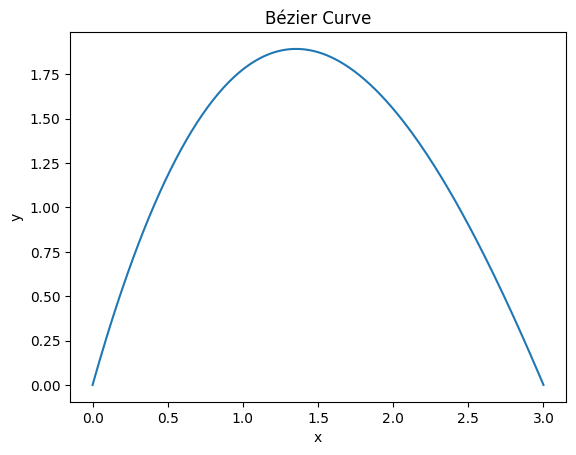

In [4]:
import bezier
import numpy as np

# Example: Creating a Cubic Bézier Curve
nodes = np.asfortranarray([
    [0.0, 1.0, 2.0, 3.0],  # x-coordinates of control points
    [0.0, 3.0, 2.0, 0.0],   # y-coordinates of control points
])
curve = bezier.Curve(nodes, degree=3)

# Evaluate the curve at a parameter value (t between 0 and 1)
s = 0.5
point = curve.evaluate(s)
print(f"Point at s={s}: {point}")

# Plot the curve (requires matplotlib)
import matplotlib.pyplot as plt

curve.plot(num_pts=256)
plt.title("Bézier Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

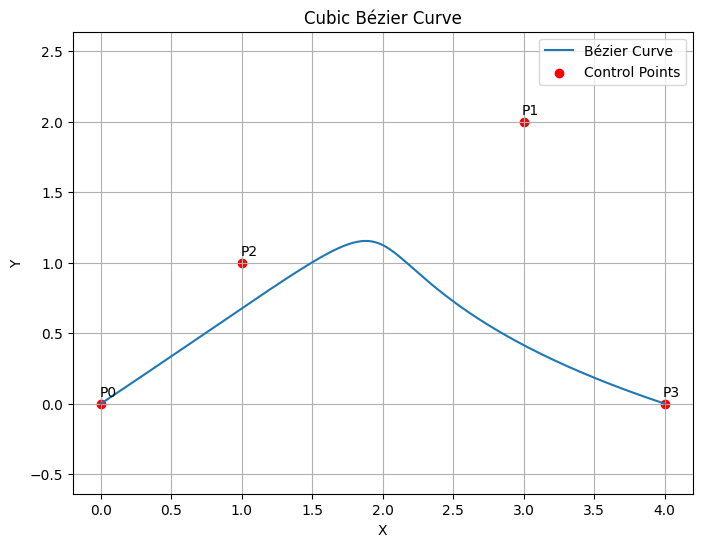

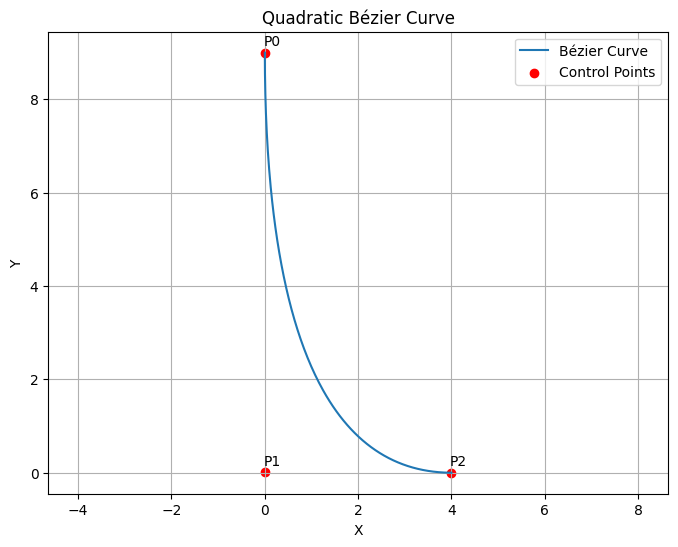

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def bezier_curve(control_points, num_points=100):
    """
    Generates a 2D Bézier curve.

    Args:
        control_points (list or numpy array): A list or NumPy array of (x, y)
            tuples or coordinates representing the control points of the Bézier curve.
            Must be a 2D array.  For a degree n curve, there should be n+1 points.

        num_points (int): The number of points to generate along the curve.
            Defaults to 100.

    Returns:
        numpy array: A NumPy array of shape (num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curve.
    """

    control_points = np.asarray(control_points)

    if control_points.ndim != 2 or control_points.shape[1] != 2:
        raise ValueError("Control points must be a 2D array of (x, y) coordinates.")

    n = control_points.shape[0] - 1  # Degree of the Bézier curve

    if n < 1:
        raise ValueError("At least two control points are required.")

    def bernstein_polynomial(i, n, t):
        """
        Calculates the i-th Bernstein basis polynomial of degree n at parameter t.
        """
        from scipy.special import comb #Combination function
        return comb(n, i) * t**i * (1 - t)**(n - i)

    points = np.zeros((num_points, 2))

    for j in range(num_points):
        t = j / (num_points - 1)  # Parameter t ranges from 0 to 1

        for i in range(n + 1):
            bernstein = bernstein_polynomial(i, n, t)
            points[j, :] += bernstein * control_points[i, :]

    return points


if __name__ == '__main__':
    # Example Usage

    # Cubic Bézier Curve
    control_points = [
        (0, 0),
        (3, 2),
        (1, 1),
        (4, 0)
    ]

    curve_points = bezier_curve(control_points, num_points=200)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points[:, 0], curve_points[:, 1], label='Bézier Curve')
    plt.scatter([p[0] for p in control_points], [p[1] for p in control_points],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Cubic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

    #Quadratic bezier curve

    control_points_quadratic = [
        (0, 9),
        (0.01, 0.01),
        (4, 0)
    ]

    curve_points_quadratic = bezier_curve(control_points_quadratic, num_points=200)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points_quadratic[:, 0], curve_points_quadratic[:, 1], label='Bézier Curve')
    plt.scatter([p[0] for p in control_points_quadratic], [p[1] for p in control_points_quadratic],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points_quadratic):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Quadratic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

In [2]:
import numpy as np

def is_monotonic(control_points):
    """
    Checks if the given control points of a Bezier curve ensure a monotonic curve.
    """
    x_coords = [p[0] for p in control_points]
    y_coords = [p[1] for p in control_points]

    # Check if x-coordinates are monotonically increasing or decreasing
    x_increasing = all(x_coords[i] <= x_coords[i+1] for i in range(len(x_coords) - 1))
    x_decreasing = all(x_coords[i] >= x_coords[i+1] for i in range(len(x_coords) - 1))

    # Check if y-coordinates are monotonically increasing or decreasing
    y_increasing = all(y_coords[i] <= y_coords[i+1] for i in range(len(y_coords) - 1))
    y_decreasing = all(y_coords[i] >= y_coords[i+1] for i in range(len(y_coords) - 1))

    #Return true if either x *and* y are monotonically increasing, or x *and* y are monotonically decreasing
    return (x_increasing and y_increasing) or (x_decreasing and y_decreasing)

# Example Usage

# Correct - Monotonic increasing in x and y
control_points1 = [
    (0, 0),
    (1, 1),
    (2, 2),
    (3, 3)
]

# Correct - Monotonic decreasing in x and y
control_points2 = [
    (3, 3),
    (2, 2),
    (1, 1),
    (0, 0)
]

# Incorrect - Not monotonic
control_points3 = [
    (0, 0),
    (1, 2),  # y is not monotonically increasing
    (2, 1),  # y decreases here
    (3, 3)
]

# Incorrect - x is not monotonic
control_points4 = [
    (0, 0),
    (2, 1),
    (1, 2),
    (3, 3)
]

print(f"Control points 1 monotonic? {is_monotonic(control_points1)}")
print(f"Control points 2 monotonic? {is_monotonic(control_points2)}")
print(f"Control points 3 monotonic? {is_monotonic(control_points3)}")
print(f"Control points 4 monotonic? {is_monotonic(control_points4)}")

Control points 1 monotonic? True
Control points 2 monotonic? True
Control points 3 monotonic? False
Control points 4 monotonic? False
